In [12]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_selection import mutual_info_regression,chi2
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, OneHotEncoder, LabelEncoder,MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import numpy as np

file_path = 'Housing.csv'  # Update with your actual file path
housing_data = pd.read_csv(file_path)
housing_data.head()


,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
0,13300000,7420,4,2,3,yes,no,no,no,yes,2,yes,furnished
1,12250000,8960,4,4,4,yes,no,no,no,yes,3,no,furnished
2,12250000,9960,3,2,2,yes,no,yes,no,no,2,yes,semi-furnished
3,12215000,7500,4,2,2,yes,no,yes,no,yes,3,yes,furnished
4,11410000,7420,4,1,2,yes,yes,yes,no,yes,2,no,furnished


In [13]:
# Convert categorical features to numerical
housing_data_encoded = housing_data.copy()
categorical_features = ['mainroad', 'guestroom', 'basement', 'hotwaterheating', 'airconditioning', 'prefarea', 'furnishingstatus']

for feature in categorical_features:
    housing_data_encoded[feature] = housing_data_encoded[feature].astype('category').cat.codes

# Task 1: Feature Selection

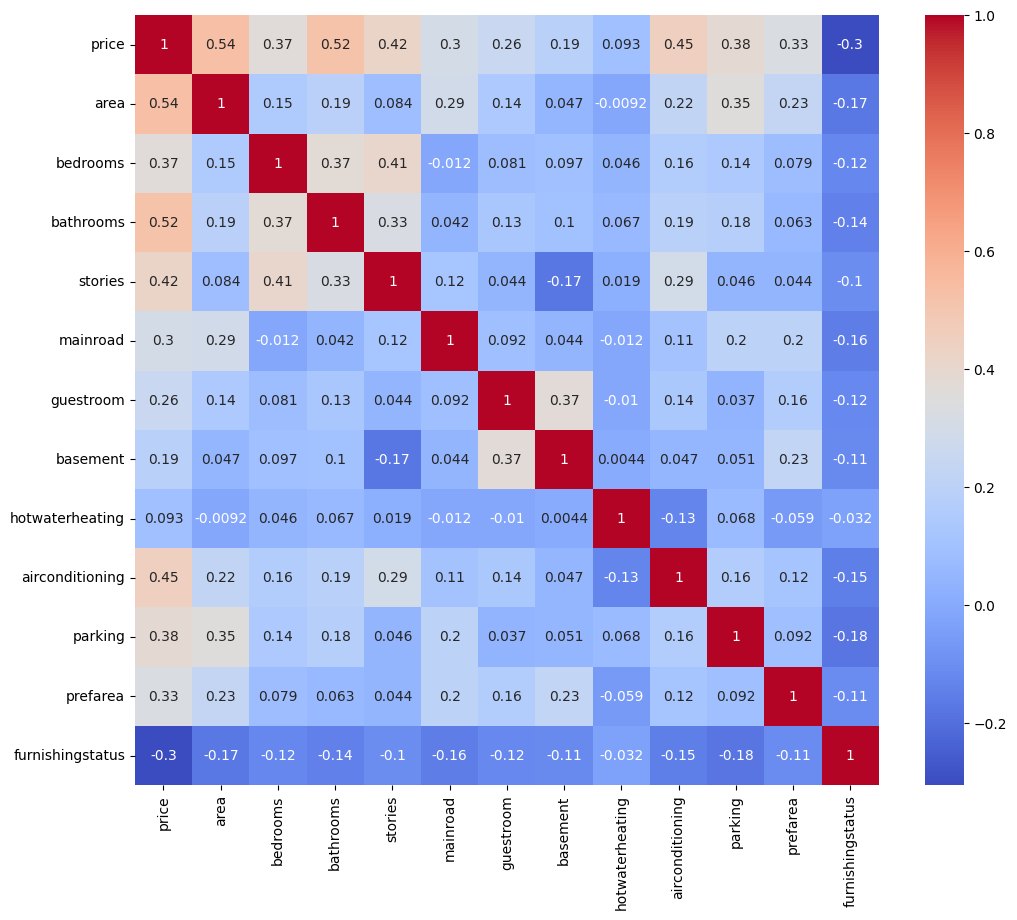

In [14]:
correlation_matrix = housing_data_encoded.corr()
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.show()

In [17]:
# Compute the mutual information between each feature and the target
X = housing_data_encoded.drop('price', axis=1)
y = housing_data_encoded['price']
mi_scores = mutual_info_regression(X, y)
mi_scores_df = pd.DataFrame(mi_scores, index=X.columns, columns=['MI Scores']).sort_values(by='MI Scores', ascending=False)
print(mi_scores_df)


X_minmax = MinMaxScaler().fit_transform(X)  # Chi-squared test requires non-negative values
chi2_scores, p_values = chi2(X_minmax, y)
chi2_df = pd.DataFrame({'Feature': X.columns, 'Chi2 Score': chi2_scores, 'p-value': p_values}).sort_values(by='Chi2 Score', ascending=False)
print(chi2_df)

                  MI Scores
area               0.182803
parking            0.167281
bathrooms          0.144050
stories            0.142600
airconditioning    0.128804
guestroom          0.112451
bedrooms           0.105442
furnishingstatus   0.103358
prefarea           0.072526
mainroad           0.053148
basement           0.041019
hotwaterheating    0.014371
             Feature  Chi2 Score   p-value
5          guestroom  248.497170  0.076489
7    hotwaterheating  224.404416  0.368579
10          prefarea  223.948555  0.376686
8    airconditioning  198.956475  0.818020
6           basement  171.888472  0.990716
2          bathrooms   96.360051  1.000000
3            stories   96.068240  1.000000
9            parking   94.275141  1.000000
11  furnishingstatus   74.532037  1.000000
4           mainroad   34.408705  1.000000
0               area   28.258733  1.000000
1           bedrooms   14.988581  1.000000


Higher MI scores indicate a stronger relationship with the target variable (price).
- Top features by MI Scores:
- area
- parking
- bathrooms
- stories
- airconditioning
- guestroom
- bedrooms
- furnishingstatus


for **chi- sqaured** the p-values are all quite high, suggesting that none of the chi-squared associations are statistically significant. This might be due to scaling or the nature of the data.

# Feature Transformation

In [18]:
# Log transformation and Standardization
housing_data_transformed = housing_data_encoded.copy()
housing_data_transformed['price'] = np.log1p(housing_data_transformed['price'])
scaler = StandardScaler()
housing_data_transformed[['area', 'bedrooms', 'bathrooms', 'stories', 'parking']] = scaler.fit_transform(housing_data_transformed[['area', 'bedrooms', 'bathrooms', 'stories', 'parking']])
print(housing_data_transformed.head())

# Compare model performance before and after transformations
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train_transformed, X_test_transformed, y_train_transformed, y_test_transformed = train_test_split(housing_data_transformed.drop('price', axis=1), housing_data_transformed['price'], test_size=0.2, random_state=42)

model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
mse_original = mean_squared_error(y_test, y_pred)

model.fit(X_train_transformed, y_train_transformed)
y_pred_transformed = model.predict(X_test_transformed)
mse_transformed = mean_squared_error(y_test_transformed, y_pred_transformed)

print(f'MSE Original: {mse_original}')
print(f'MSE Transformed: {mse_transformed}')

       price      area  bedrooms  bathrooms   stories  mainroad  guestroom  \
0  16.403275  1.046726  1.403419   1.421812  1.378217         1          0   
1  16.321037  1.757010  1.403419   5.405809  2.532024         1          0   
2  16.321037  2.218232  0.047278   1.421812  0.224410         1          0   
3  16.318175  1.083624  1.403419   1.421812  0.224410         1          0   
4  16.250001  1.046726  1.403419  -0.570187  0.224410         1          1   

   basement  hotwaterheating  airconditioning   parking  prefarea  \
0         0                0                1  1.517692         1   
1         0                0                1  2.679409         0   
2         1                0                0  1.517692         1   
3         1                0                1  2.679409         1   
4         1                0                1  1.517692         0   

   furnishingstatus  
0                 0  
1                 0  
2                 1  
3                 0  
4     

**Clearly it can be seen that before data transformation mean sqaure error was much larger as compared to after transformation.Hence data transfomatio proved beneficial and will increase the accuracy of the model **

# Feature Creation

In [19]:
housing_data_encoded['total_rooms'] = housing_data_encoded['bedrooms'] + housing_data_encoded['bathrooms']
housing_data_encoded['area_per_room'] = housing_data_encoded['area'] / housing_data_encoded['total_rooms']
print(housing_data_encoded.head())

# Compare model performance with new features
X_new = housing_data_encoded.drop('price', axis=1)
y_new = housing_data_encoded['price']
X_train_new, X_test_new, y_train_new, y_test_new = train_test_split(X_new, y_new, test_size=0.2, random_state=42)

model.fit(X_train_new, y_train_new)
y_pred_new = model.predict(X_test_new)
mse_new_features = mean_squared_error(y_test_new, y_pred_new)

print(f'MSE with New Features: {mse_new_features}')

      price  area  bedrooms  bathrooms  stories  mainroad  guestroom  \
0  13300000  7420         4          2        3         1          0   
1  12250000  8960         4          4        4         1          0   
2  12250000  9960         3          2        2         1          0   
3  12215000  7500         4          2        2         1          0   
4  11410000  7420         4          1        2         1          1   

   basement  hotwaterheating  airconditioning  parking  prefarea  \
0         0                0                1        2         1   
1         0                0                1        3         0   
2         1                0                0        2         1   
3         1                0                1        3         1   
4         1                0                1        2         0   

   furnishingstatus  total_rooms  area_per_room  
0                 0            6    1236.666667  
1                 0            8    1120.000000  
2       

**Two more features are created to increase the accuracy of the model so that i has more data on which it can be trained. greater the data greater the accuracy of the model but as the mse of new dat suggests that addition of these two features is not beneficial for the model. This suggests that either the new features created were not highly informative or that they were not utilized effectively by the model.**

# Polynomial features

In [27]:
poly = PolynomialFeatures(degree=2, include_bias=False)
X_poly_train = poly.fit_transform(X_train)
X_poly_test = poly.transform(X_test)

# Initialize and train a linear regression model
model = LinearRegression()
model.fit(X_poly_train, y_train)

# Making predictions on the test set
y_pred = model.predict(X_poly_test)

# Calculating mean squared error
mse_poly_features = mean_squared_error(y_test, y_pred)

print(f'MSE with Polynomial Features: {mse_poly_features}')

MSE with Polynomial Features: 1769664142737.4473


The MSE with polynomial features is also high, indicating that simply adding polynomial features didn't lead to a significant improvement in model performance either. This suggests that the relationship between the features and the target variable (price) may not be well-captured by polynomial transformations alone.

# Handling Categorical Features

already done in first part since dataset was not numerical